### Machine Learning

- Maria Zazpe Quintana

- Alba Rodríguez Berenguel

## Análisis de puntuación de comercios

### Descripción del problema

El objetivo es realizar todos los pasos hasta construir un modelo de Machine Learning que sea capaz de predecir la probabilidad de que un comercio, en nuestro caso restaurantes, obtenga un puntuación alta por parte de un usuario experimentado, que tenga mayor criterio y experiencia.

Para ello vamos a llevar a cabo un análisis de los datos, haremos las transformaciones necesarias y construiremos distintos modelos. Nos quedaremos con aquel que nos devuelva una predicción más precisa. Esto podría ayudar a este tipo de negocios a saber qué mejoras podrían implementar para obtener mejor puntuación, y por consiguiente, atraer más clientes.

### Descripción del dataset

Los datos los hemos obtenido de Yelp Open Dataset que ofrecen dataset con información sobre negocios, reseñas y usuarios. A partir de ellos hemos construido un dataset con reseñas de restaurantes que han realizado usuarios *experimentados* (aquellos que han publicado más de 100 reseñas). 

Cada fila corresponde a una reseña y cada columna a una variable. Las variables que tenemos son los id's, tanto de usuarios como de empresas; el estado en el que se encuentra el restaurante; los atributos que pueden tener (disponer de wifi, servicio de terraza o de envío, etc.) y las opiniones de las reseñas.

La variable target es la columna *stars* que hace referencia a la puntuación que ha dado el usuario al restaurante en la reseña. Se valora mediante el número de estrellas que van del 1 al 5, considerando puntuación alta a partir del 4.

En este notebook vamos a realizar un análisis EDA para conocer mejor los datos y realizar algunas transformaciones iniciales que sean necesarias. Los pasos que vamos a seguir son los siguientes:

1. Carga de los datos.
2. Análisis general de la tabla.
3. Exploración de la variable target y tratamiento.
4. Tratamiento de valores missing.
5. Tipos de variables: categóricas y numéricas.
6. Exportación de los datos.

In [1]:
# Libraries
import pandas as pd
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Functions
def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_outlier_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores outliers')
        
    return pd_final

def cramers_V(var1,var2) :
    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    stat = chi2_contingency(crosstab)[0]
    obs = np.sum(crosstab)
    mini = min(crosstab.shape)-1
    return (stat/(obs*mini))

## 1. Carga de los datos

In [3]:
# We create a list with the names of each column to modify the original ones because some contain capital letters and it is 
# less practical.
new_names = ['business_id', 'state', 'delivery', 'outdoor_seating', 'credit_cards', 'bike_parking', 'price_range', 
             'take_out', 'wifi', 'alcohol', 'caters', 'wheelchair_accessible', 'good_for_kids', 'attire', 'reservations', 
             'table_service', 'good_for_groups', 'tv', 'noise_level','user_id', 'stars', 'useful', 'funny', 'cool', 
             'review_count']

# We read the csv file that we save in the previous notebook     
reviews_df = pd.read_csv("../data/raw/reviews_final.csv")

# We change column names
reviews_df.columns = new_names

reviews_df.head()

,business_id,state,delivery,outdoor_seating,credit_cards,bike_parking,price_range,take_out,wifi,alcohol,...,table_service,good_for_groups,tv,noise_level,user_id,stars,useful,funny,cool,review_count
0,MTSW4McQd7CbVtyjqoe9mw,PA,False,False,False,True,1.0,True,u'free',u'none',...,NaN,NaN,NaN,NaN,tCXElwhzekJEH6QJe3xs7Q,4,3,1,2,163
1,U30ggGzFpXvc2NZYwOW3qg,PA,True,True,True,True,1.0,True,u'no',u'none',...,NaN,True,True,u'quiet',tCXElwhzekJEH6QJe3xs7Q,5,12,4,5,163
2,EtKSTHV5Qx_Q7Aur9o4kQQ,PA,True,True,True,True,2.0,True,u'no',u'full_bar',...,True,False,False,u'average',tCXElwhzekJEH6QJe3xs7Q,5,1,0,1,163
3,IH_ZeeTh13jQURbh31d1Kw,PA,False,False,False,True,1.0,True,u'no','none',...,NaN,True,False,u'average',tCXElwhzekJEH6QJe3xs7Q,4,1,0,0,163
4,YqmClmk7oLcDzPWKHzgA-Q,PA,True,True,True,True,2.0,True,u'no',u'full_bar',...,True,True,True,u'average',tCXElwhzekJEH6QJe3xs7Q,4,5,1,2,163


Vamos a realizar el análisis EDA con la totalidad de los datos y una vez hechas las transformaciones lo dividiremos en train y test, para continuar con el modelado.

## 2. Análisis general de la tabla.

In [4]:
# Duplicated values
print(reviews_df.shape, reviews_df.drop_duplicates().shape)

(1095247, 25) (1088022, 25)


El dataset contiene 25 variables y 1095247 filas. Si eliminamos los duplicados las filas disminuirían a 1088022. 

In [5]:
# We remove duplicate rows
reviews_df = reviews_df.drop_duplicates()

Hemos decidido que sí vamos a eliminar los duplicados, ya que al estar cada reseña identificada con el *user_id* y *business_id*, significa que el mismo usuario ha publicado la misma reseña para un restaurante varias veces, con las mismas valoraciones, por lo que no necesitamos tenerla duplicada y cabe la posbilidad de que sea un error.

In [6]:
# Vemos el tipo de variables
reviews_df.dtypes.to_dict()

{'business_id': dtype('O'),
 'state': dtype('O'),
 'delivery': dtype('O'),
 'outdoor_seating': dtype('O'),
 'credit_cards': dtype('O'),
 'bike_parking': dtype('O'),
 'price_range': dtype('O'),
 'take_out': dtype('O'),
 'wifi': dtype('O'),
 'alcohol': dtype('O'),
 'caters': dtype('O'),
 'wheelchair_accessible': dtype('O'),
 'good_for_kids': dtype('O'),
 'attire': dtype('O'),
 'reservations': dtype('O'),
 'table_service': dtype('O'),
 'good_for_groups': dtype('O'),
 'tv': dtype('O'),
 'noise_level': dtype('O'),
 'user_id': dtype('O'),
 'stars': dtype('int64'),
 'useful': dtype('int64'),
 'funny': dtype('int64'),
 'cool': dtype('int64'),
 'review_count': dtype('int64')}

Todas las variables son categoricas menos starts, useful, funny y cool. Más adelante analizaremos los valores unicos de cada variable para confirmarlo.

## 3. Exploración de la variable target y tratamiento.

Nuestra variable target es *stars*, que se refiere al numero de estrellas que dan a un restaurante en una reseña. Esta puede tomar los valores 1, 2, 3, 4 o 5, por lo que vamos a codificarla ya que solo nos interesa saber si es puntuación alta (4 o 5 estrellas) o puntuación baja (1, 2 o 3 estrellas). Entonces, asignaremos un 1 a las puntuaciones altas y un 0 a las bajas.

In [7]:
# We assign 1 if it has a value of 4 or 5 and 0 if not.
reviews_df['stars'] = reviews_df['stars'].apply(lambda x:1 if x in [4,5] else 0)

In [8]:
# We move the column stars so that it is on the right
# We extract the column
mov_stars = reviews_df.pop('stars')

# We insert the column at the final
reviews_df.insert(len(reviews_df.columns), "stars", mov_stars)

reviews_df.head()

,business_id,state,delivery,outdoor_seating,credit_cards,bike_parking,price_range,take_out,wifi,alcohol,...,table_service,good_for_groups,tv,noise_level,user_id,useful,funny,cool,review_count,stars
0,MTSW4McQd7CbVtyjqoe9mw,PA,False,False,False,True,1.0,True,u'free',u'none',...,NaN,NaN,NaN,NaN,tCXElwhzekJEH6QJe3xs7Q,3,1,2,163,1
1,U30ggGzFpXvc2NZYwOW3qg,PA,True,True,True,True,1.0,True,u'no',u'none',...,NaN,True,True,u'quiet',tCXElwhzekJEH6QJe3xs7Q,12,4,5,163,1
2,EtKSTHV5Qx_Q7Aur9o4kQQ,PA,True,True,True,True,2.0,True,u'no',u'full_bar',...,True,False,False,u'average',tCXElwhzekJEH6QJe3xs7Q,1,0,1,163,1
3,IH_ZeeTh13jQURbh31d1Kw,PA,False,False,False,True,1.0,True,u'no','none',...,NaN,True,False,u'average',tCXElwhzekJEH6QJe3xs7Q,1,0,0,163,1
4,YqmClmk7oLcDzPWKHzgA-Q,PA,True,True,True,True,2.0,True,u'no',u'full_bar',...,True,True,True,u'average',tCXElwhzekJEH6QJe3xs7Q,5,1,2,163,1


Una vez codificada, vamos a comprobar la distribución de la variable para ver si está desbalanceada.

In [9]:
# I add the values for each category (0 and 1) and calculate their percentage
reviews_df_plot = reviews_df['stars']\
        .value_counts(normalize = True)\
        .mul(100).rename('percent').reset_index()

# I add the values for each category (0 and 1)
reviews_df_plot_conteo = reviews_df['stars'].value_counts().reset_index()

# I join the previous results
reviews_df_plot_concat = pd.merge(reviews_df_plot, 
                                  reviews_df_plot_conteo, on=['index'], how='inner')

reviews_df_plot_concat

,index,percent,stars
0,1,72.16196,785138
1,0,27.83804,302884


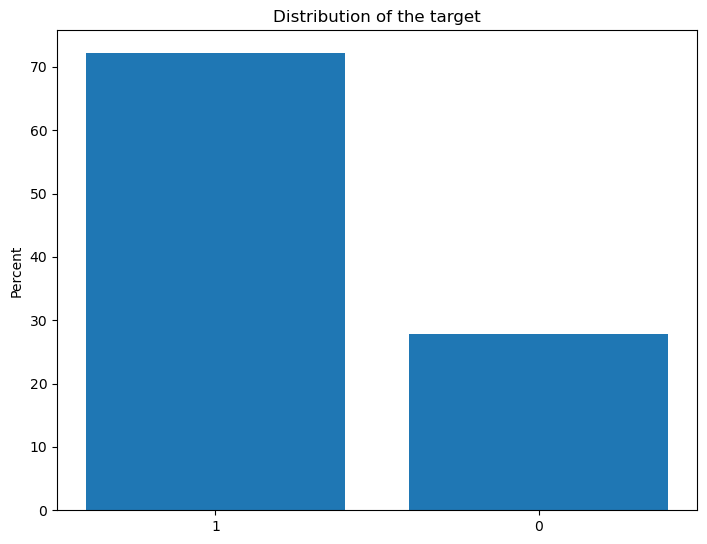

In [10]:
# Visualizamos el resultado
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ['1', '0']
perc = reviews_df_plot_concat['percent']
ax.bar(lab, perc)
ax.set_title('Distribution of the target')
ax.set_ylabel('Percent')
plt.show()

El dataset está desbalanceado en favor de la puntuación alta (1). Hay un 72,16% de puntuaciones alta y 27,84% de puntuaciones bajas.

## 4. Tratamiento de valores missing.

In [11]:
# Firstly, we will calculete the nulls of the columns
# We add the null values by columns, order them descending and transform the series into a dataframe
reviews_df_null_columns = reviews_df.isnull().sum().sort_values(ascending=False).to_frame('columns_null').reset_index()

# We add a column with the percentage of nulls
reviews_df_null_columns['columns_percentage'] = reviews_df_null_columns['columns_null']/reviews_df.shape[0] * 100

reviews_df_null_columns

,index,columns_null,columns_percentage
0,wheelchair_accessible,590177,54.243113
1,table_service,465804,42.812002
2,attire,225545,20.729820
3,good_for_groups,174178,16.008684
4,good_for_kids,170354,15.657220
5,reservations,162382,14.924514
6,noise_level,160854,14.784076
7,tv,157794,14.502832
8,alcohol,154987,14.244841
9,caters,138612,12.739816


Tenemos algunas variables con porcentaje alto de nulos, las variables *wheelchair_accessible* y *table_service* son las que tienen más tienen, superando ambas el 40%. No obstante, no las vamos a eliminar ya que en la mayoría de sitios web de reseñas no es obligatorio introducir todos los atributos y lo más razonable es pensar que simplemente estos establecimientos no tienen esos atributos. Las trataremos posteriormente en el preprocesado.

In [12]:
# Second, we will calculete the nulls of the rows
# We add the null values by rows and order them descending
reviews_df_null_rows = reviews_df.isnull().sum(axis=1).sort_values(ascending=False)

# We transform the series into a dataframe
reviews_df_null_rows = pd.DataFrame(reviews_df_null_rows, columns=['rows_null']) 

# We add a column to check if there is any row with the target variable missing.
reviews_df_null_rows['target'] = reviews_df['stars'].copy()

# We add a column with the percentage of nulls
reviews_df_null_rows['rows_percentage']= reviews_df_null_rows['rows_null']/reviews_df.shape[1] * 100

reviews_df_null_rows

,rows_null,target,rows_percentage
300067,17,1,68.0
890200,17,1,68.0
308302,17,1,68.0
243985,17,1,68.0
1088326,17,1,68.0
...,...,...,...
718060,0,0,0.0
225801,0,1,0.0
718056,0,1,0.0
718054,0,1,0.0


Tenemos algunas filas que llegan a alcanzar el 77,27% de nulos que les faltan 17 variables, eso es practicamente todos los atributos que puede tener un restaurante. Vamos a eliminar aquellas que tengan más del 40% de valores nulos.

In [13]:
nulls_40 = list(reviews_df_null_rows.index[reviews_df_null_rows['rows_percentage'] > 40])

reviews_df = reviews_df.drop(index = nulls_40)

reviews_df.shape

(1009579, 25)

Tras eliminar las filas con un 40% de nulos, nos hemos quedado con 962687 filas.

## 5. Tipos de variables: categóricas y numéricas.

In [14]:
# We check the unique values of each variable
for i in reviews_df.columns:
    print(i, reviews_df[i].unique())

business_id ['MTSW4McQd7CbVtyjqoe9mw' 'U30ggGzFpXvc2NZYwOW3qg'
 'EtKSTHV5Qx_Q7Aur9o4kQQ' ... 'itrLY7yXwYW7GB3lju9Qag'
 'idrUCWKpIX7iwoX7xNBcqg' '8BUr8GviR2o_b-brO21wwQ']
state ['PA' 'AZ' 'TN' 'NJ' 'FL' 'DE' 'CA' 'LA' 'MO' 'NV' 'ID' 'IN' 'AB' 'IL']
delivery ['False' 'True' 'None' nan]
outdoor_seating ['False' 'True' 'None' nan]
credit_cards ['False' 'True' nan 'None' True False]
bike_parking ['True' 'False' nan 'None' True False]
price_range [1.0 2.0 3.0 4.0 nan '1' '2' '3' '4' 'None']
take_out ['True' 'None' nan 'False']
wifi ["u'free'" "u'no'" "'free'" "'no'" nan "u'paid'" "'paid'" 'None']
alcohol ["u'none'" "u'full_bar'" "'none'" "'full_bar'" "u'beer_and_wine'" nan
 "'beer_and_wine'" 'None']
caters ['True' 'False' nan 'None']
wheelchair_accessible [nan True False 'True' 'False' 'None']
good_for_kids [nan 'True' 'False' 'None' False True]
attire [nan "u'casual'" "'casual'" "u'dressy'" "'dressy'" "u'formal'" 'None'
 "'formal'"]
reservations [nan 'False' 'True' 'None']
table_service [na

Todas las variable son categóricas excepto *useful*, *funny* y *cool*, que son las únicas que no tienen categorías en sus valores. Vamos a crear dos listas para cada uno de los tipos y estableceremos los tipos correctos.

In [15]:
# We create two lists to classify the variables in categorical or numeric
var_category = ['state', 'delivery', 'outdoor_seating', 'credit_cards', 'bike_parking', 'price_range', 'take_out', 
                'wifi', 'alcohol', 'caters', 'wheelchair_accessible', 'good_for_kids', 'attire', 'reservations', 
                'table_service', 'good_for_groups', 'tv', 'noise_level', 'stars']

var_num = ['useful', 'funny', 'cool']

In [16]:
# Transformation of categorical variables
reviews_df[var_category] = reviews_df[var_category].astype("object")

In [17]:
# We check the types
reviews_df.dtypes

business_id              object
state                    object
delivery                 object
outdoor_seating          object
credit_cards             object
bike_parking             object
price_range              object
take_out                 object
wifi                     object
alcohol                  object
caters                   object
wheelchair_accessible    object
good_for_kids            object
attire                   object
reservations             object
table_service            object
good_for_groups          object
tv                       object
noise_level              object
user_id                  object
useful                    int64
funny                     int64
cool                      int64
review_count              int64
stars                    object
dtype: object

Las variables *useful*, *funny* y *cool* mantienen su tipo original que es el correcto.

#### Grafo relación usuarios - restaurantes. 

En primer lugar, para comprender mejor los datos de los que disponemos, vamos a tomar una muestra del data frame y construir un grafo, para visualizar la relación que hay entre los usuarios y los restaurantes. 

No vamos a representar el dataset completo porque son aproximadamente unos 55.000 restaurantes distintos y 80.000 usuarios, y no se visualizarían correctamente. Además, solo queremos comprender la relación, por lo que una muestra nos resulta suficiente.

In [18]:
# We select the columns 'user_id' and 'business_id'
data_filter = reviews_df[['user_id', 'business_id']]

# We take a sample of 1000 rows.
data_filter = data_filter[0:500]

# We are going to change the id's that identify businesses and users to make them easier to view. 
#We are going to replace them for users by user_1, user_2... And for restaurants by rest_1, rest_2-
data_filter['user_id'] = pd.factorize(data_filter['user_id'])[0] + 1
data_filter['user_id'] = data_filter['user_id'].map(lambda x: 'user_{}'.format(x))

data_filter['business_id'] = pd.factorize(data_filter['business_id'])[0] + 1
data_filter['business_id'] = data_filter['business_id'].map(lambda x: 'rest_{}'.format(x))

data_filter.head()

,user_id,business_id
0,user_1,rest_1
1,user_1,rest_2
2,user_1,rest_3
3,user_1,rest_4
4,user_1,rest_5


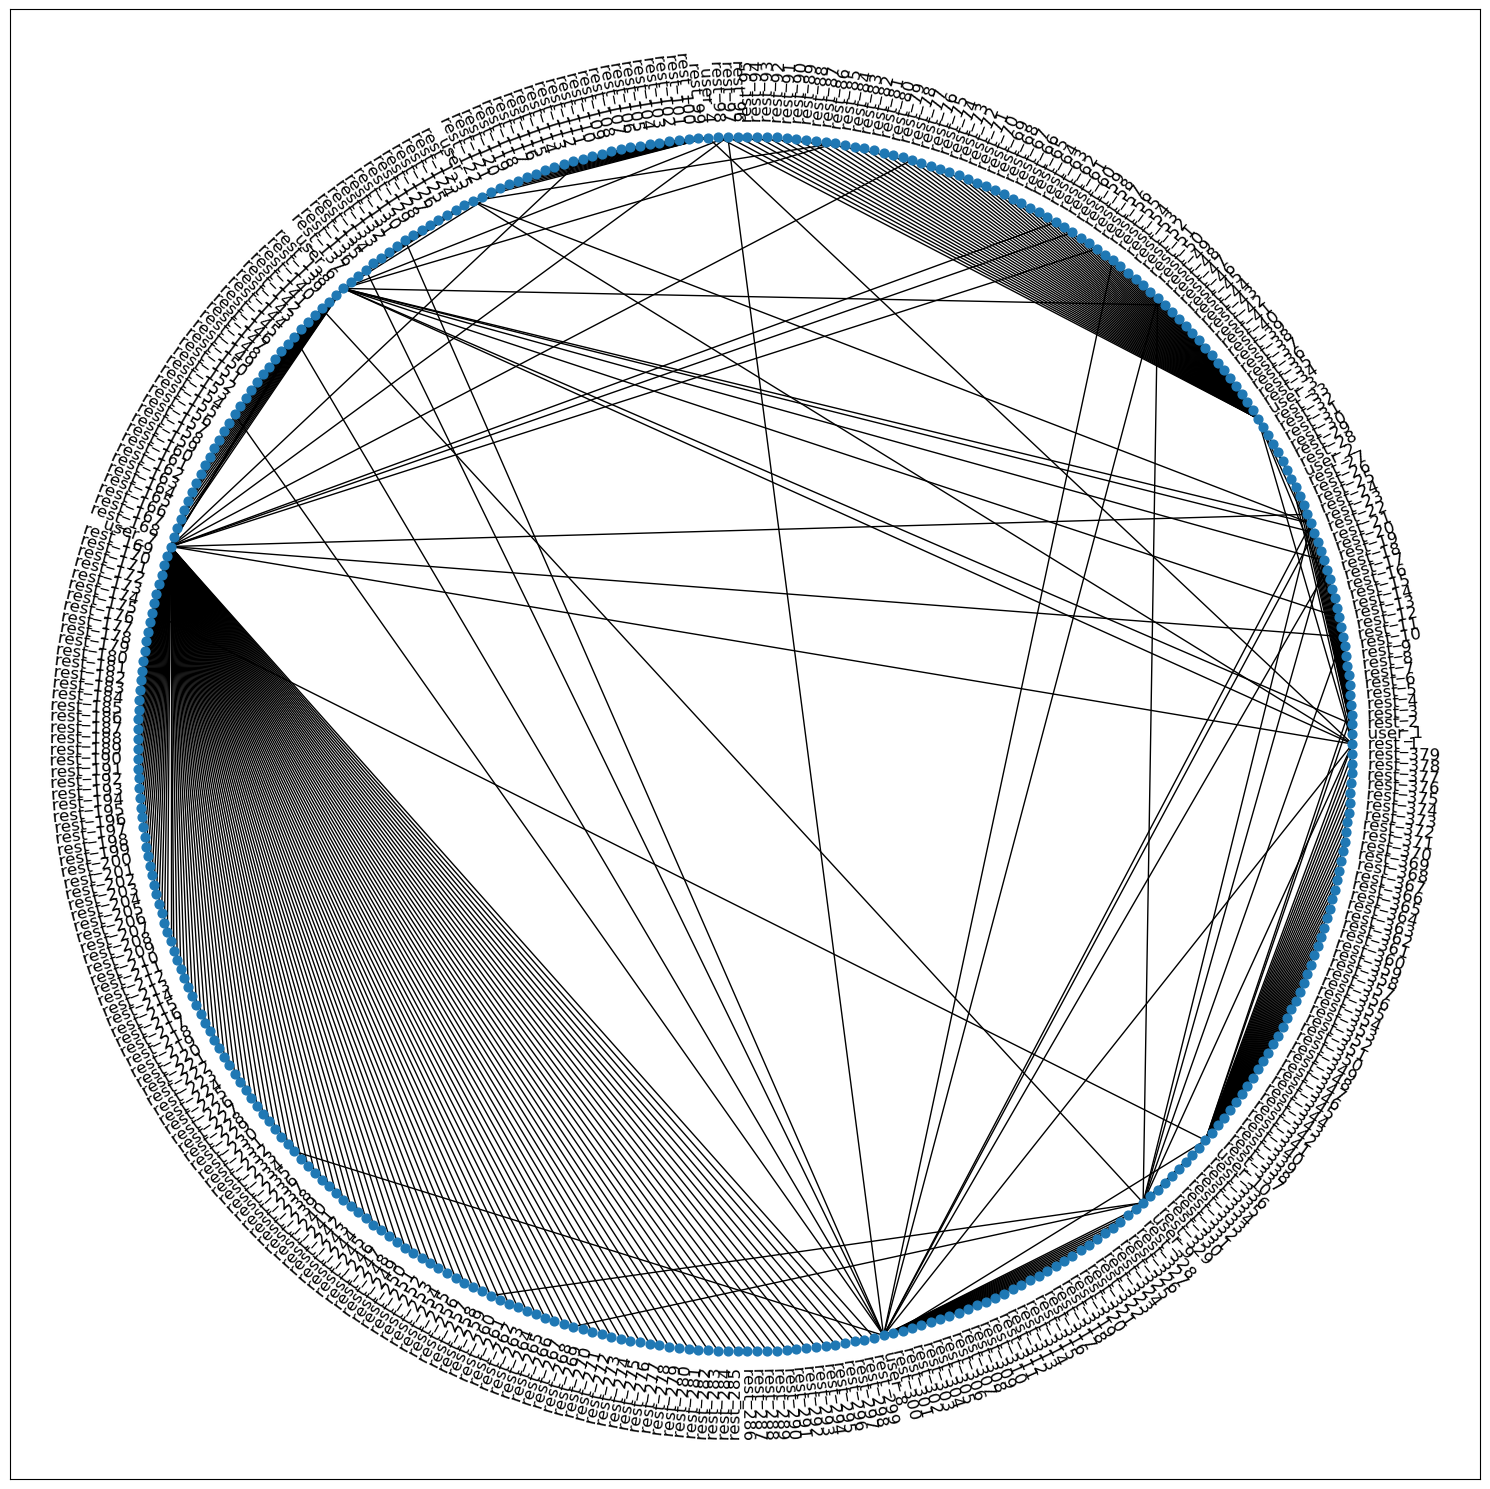

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))

df = (data_filter
    .assign(**{'user_id': lambda df: '   ' + df['user_id'] + '   '})
    .assign(**{'business_id': lambda df: '   ' + df['business_id'] + '   '})
)

g = nx.from_pandas_edgelist(df, source='business_id', target='user_id')

node_locs = nx.circular_layout(g)
theta = {k: np.arctan2(v[1], v[0]) * 180 / np.pi for k, v in node_locs.items()}

nx.draw_networkx_nodes(g, pos=node_locs, node_size=40)
labels = nx.draw_networkx_labels(g, pos=node_locs, horizontalalignment='left')

for key, t in labels.items():
    if 90 < theta[key] or theta[key] < -90:
        angle = 180 + theta[key]
        t.set_ha('right')
    else:
        angle = theta[key]
        t.set_ha('left')
    t.set_va('center')
    t.set_rotation(angle)
    t.set_rotation_mode('anchor')

nx.draw_networkx_edges(g, pos=node_locs)

plt.tight_layout()

plt.show()

En el grafo se aprecia como un mismo usuario puede realizar reviews de distintos restaurantes, de ahí que hayamos considerado los usuarios experimentados, porque nos interesan los que visitan distintos sitios, por lo que pueden formar una opinión más crítica al compararlos.

La mayoría de los nodos son restaurantes, usuarios son apenas 10, pero visitan bastantes establecimientos cada uno de ellos, y también hay usuarios que coinciden en algunos, como el caso por ejemplo del usuario 7 y el 9 en los restaurantes 259 y 268.

### 5.1 Variables categóricas.

#### Puntuaciones en cada estado. 

En primer lugar, vamos a aprovechar las visualizaciones geoespaciales para comprobar la distribución de estrellas por estados y cuáles de ellos tienen puntuaciones más altas.

In [20]:
# We read the file where the map that we are going to use for the geospatial visualization is located
geo_data = gpd.read_file("../data/geoespacial/USA_States.shp").sort_values('STATE_ABBR')

# We create a df with the sum of the stars in each state
agg_state_stars = reviews_df.groupby('state', as_index=False).agg({'stars' : 'sum'})

# we change the name of the column by which we are going to join
geo_data = geo_data.assign(**{'state': lambda df: df['STATE_ABBR']})

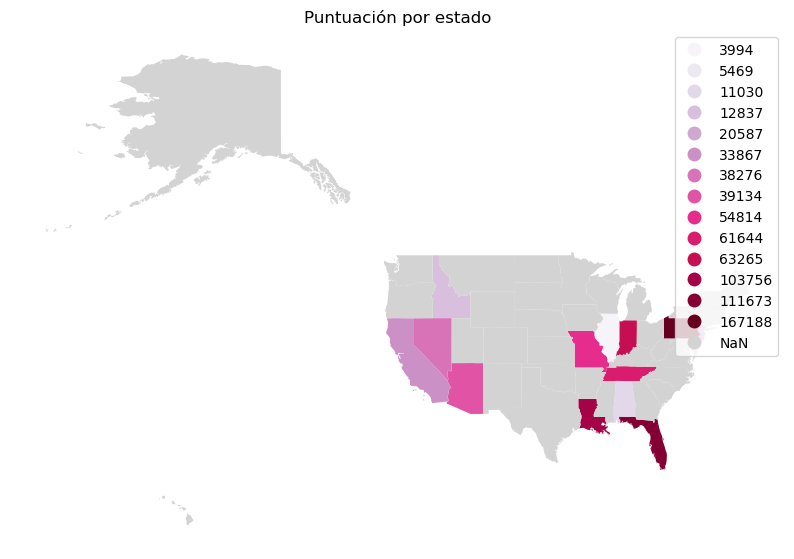

In [21]:
(geo_data
    .assign(**{'state': lambda df: df['state'].replace({
        'AL': 'AB'
    })})
    .dissolve(by='state')
    .merge(agg_state_stars, on='state', how='left')
    .plot('stars', legend = True, figsize = (10,20), 
          cmap = "PuRd", missing_kwds={'color': 'lightgrey'})
    .set_title('Puntuación por estado')
)
plt.axis("off")
plt.show()

Los colores más oscuros corrresponden a los estados que tienen más puntuaciones altas. Estos son Pensilvania(PA), Florida (FL) y Los Ángeles (LA). Por el contrario, los que tienen puntuaciones más bajas son los restaurantes de Illinois (IL) y Delaware (DE). 

Vamos a comprobar el número de reseñas que hay en cada estado.

In [22]:
# We create a df with the number of the reviews that there are in each state
agg_state = reviews_df.groupby('state', as_index=False).agg({'stars' : 'count'})

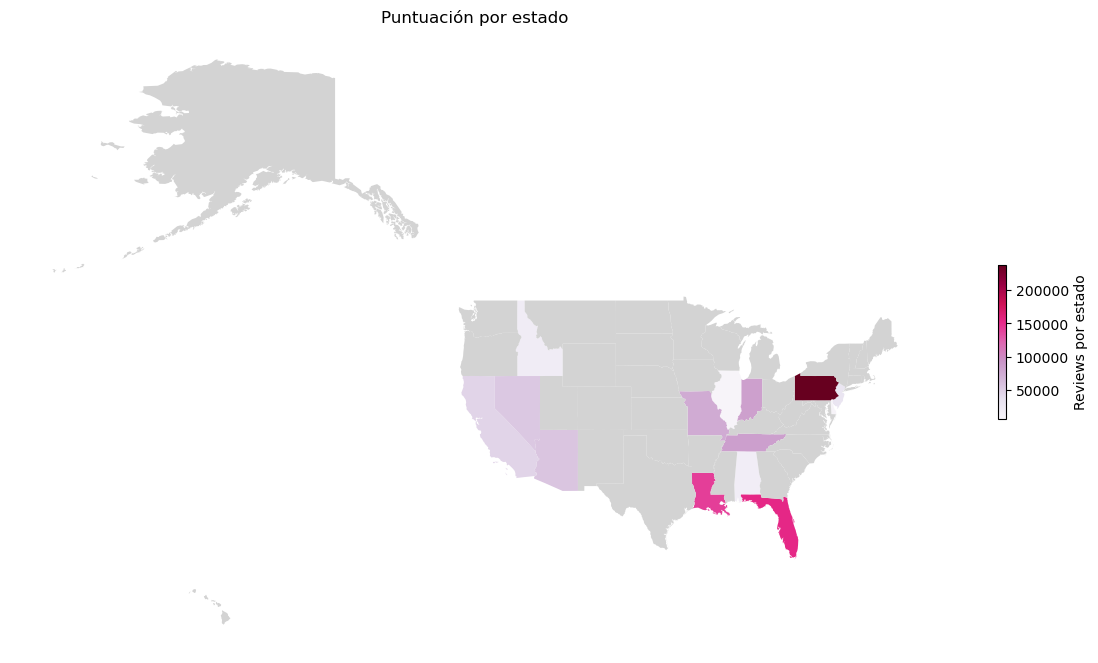

In [23]:
(geo_data
    .assign(**{'state': lambda df: df['state'].replace({
        'AL': 'AB'
    })})
    .dissolve(by='state')
    .merge(agg_state, on='state', how='left')
    .plot('stars', legend = True, figsize = (15,20), legend_kwds={'label': "Reviews por estado", 'shrink': 0.1},
          cmap = "PuRd", missing_kwds={'color': 'lightgrey'})
    .set_title('Puntuación por estado')
)
plt.axis("off")
plt.show()

En este mapa se puede comprobar que estos estados también corresponden a los que mayor número de reseñas tienen, por lo que no son comparables. Si cabe destacar que estos estados son algunos de los más turísticos del país, por lo que es razonable que tengan mayor número de reviews porque reciben más visitantes.

#### Puntuación según servicio de reparto 

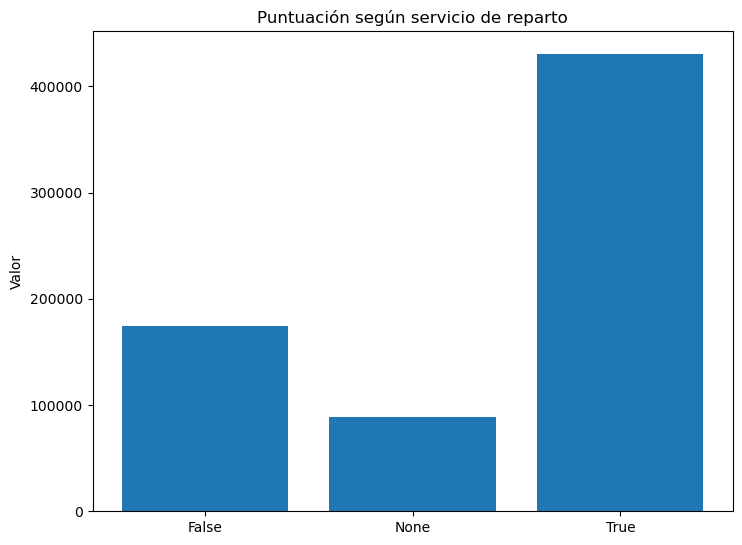

In [24]:
# We create a dataframe by grouping the data based on delivery and adding the stars.
delivery_stars = reviews_df[['delivery', 'stars']].groupby('delivery')['stars'].sum().to_frame().reset_index()

# We visualize the results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = list(delivery_stars['delivery'])
stars = delivery_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación según servicio de reparto')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si dispone de delivery, False si no y None si se desconoce. Los restaurantes que sí ofrecen este servicio tienen puntuaciones más altas.

#### Puntuación según de terraza

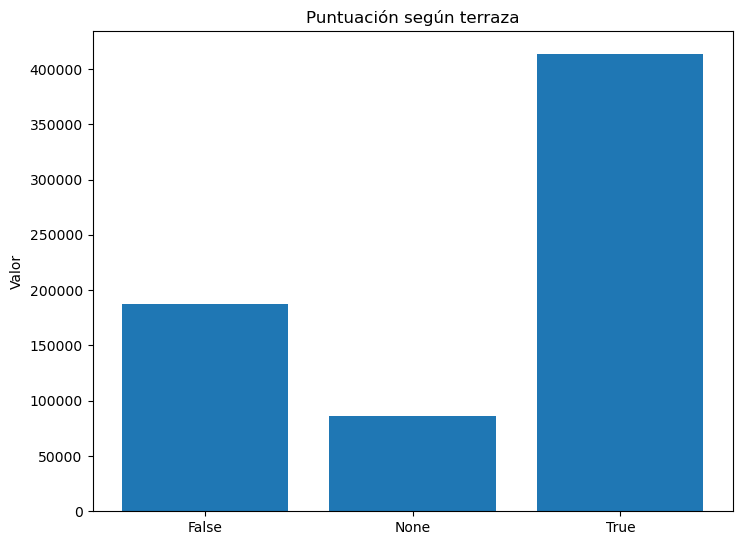

In [25]:
# We create a dataframe by grouping the data based on outdoor_seating and adding the stars.
outdoor_stars = reviews_df[['outdoor_seating', 'stars']].groupby('outdoor_seating')['stars'].sum().to_frame().reset_index()

# We visualize the results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = lab = list(outdoor_stars['outdoor_seating'])
stars = outdoor_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación según terraza')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si dispone de terraza, False si no y None si se desconoce. Los restaurantes que sí ofrecen este servicio tienen puntuaciones más altas.

#### Puntuación dependiendo de si aceptan tarjetas de credito. 

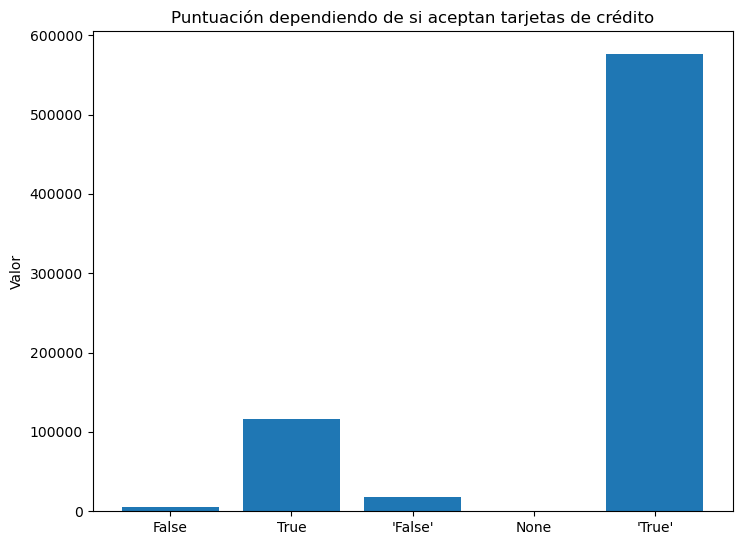

In [26]:
# We create a dataframe by grouping the data based on credit_cards and adding the stars.
card_stars = reviews_df[['credit_cards', 'stars']].groupby('credit_cards')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ["False", "True", "'False'", "None", "'True'"]
stars = card_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación dependiendo de si aceptan tarjetas de crédito')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si dispone de terraza, False si no y None si se desconoce. Los restaurantes que sí aceptan tarjetas de crédito como forma de pago tienen puntuaciones más altas. La categoria de True y False están duplicadas, ya que algunos valores son tipo *str* y otros *bool*, de esto nos encargaremos en el preprocesado uniéndolas.

#### Puntuación según aparcamiento para bicicletas.

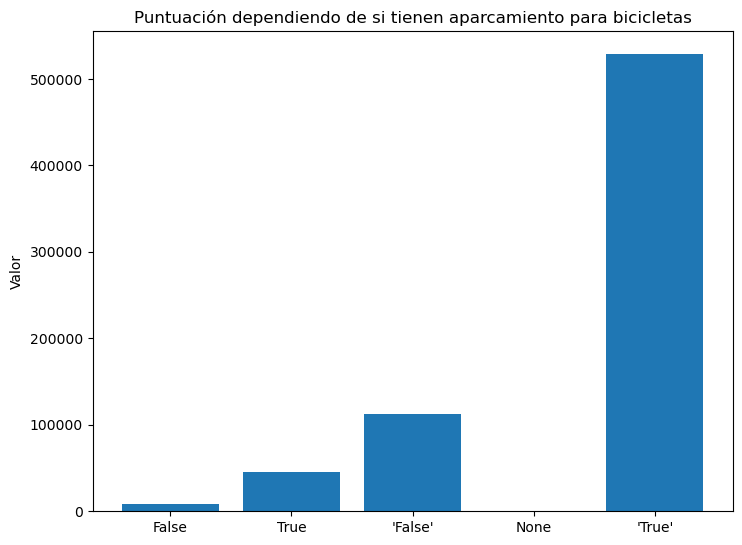

In [27]:
# We create a dataframe by grouping the data based on bike_parking and adding the stars.
bike_stars = reviews_df[['bike_parking', 'stars']].groupby('bike_parking')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ["False", "True", "'False'", "None", "'True'"]
stars = bike_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación dependiendo de si tienen aparcamiento para bicicletas')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si dispone de aparcamiento para bicicletas, False si no y None si se desconoce. Los restaurantes que sí tienen obtienen puntuaciones más altas. La categoria de True y False están duplicadas, ya que algunos valores son tipo *str* y otros *bool*, de esto nos encargaremos en el preprocesado uniéndolas.

#### Puntuación según el rango de precios 

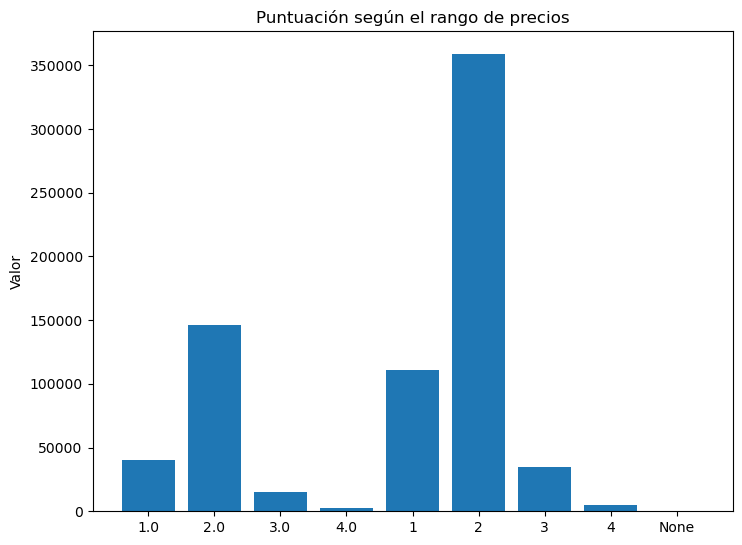

In [28]:
# We create a dataframe by grouping the data based on price_range and adding the stars.
price_stars = reviews_df[['price_range', 'stars']].groupby('price_range')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ['1.0', '2.0', '3.0', '4.0', '1', '2', '3', '4', 'None']
stars = price_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación según el rango de precios')
ax.set_ylabel('Valor')
plt.show()

La variable toma valores entre el 1 y el 4, yendo de más barato a más caro. Los restaurante con un rango de precios 2 son los que tienen más estrellas, seguidos de los que tienen valor 1 (los más baratos). Los que tienen un precios más caro (4) son los que peor puntuación tienen. Las categorias están duplicadas, ya que algunos valores son tipo *str* y otros *float*, de esto nos encargaremos en el preprocesado uniéndolas.

#### Puntuación según servicio de comida para llevar 

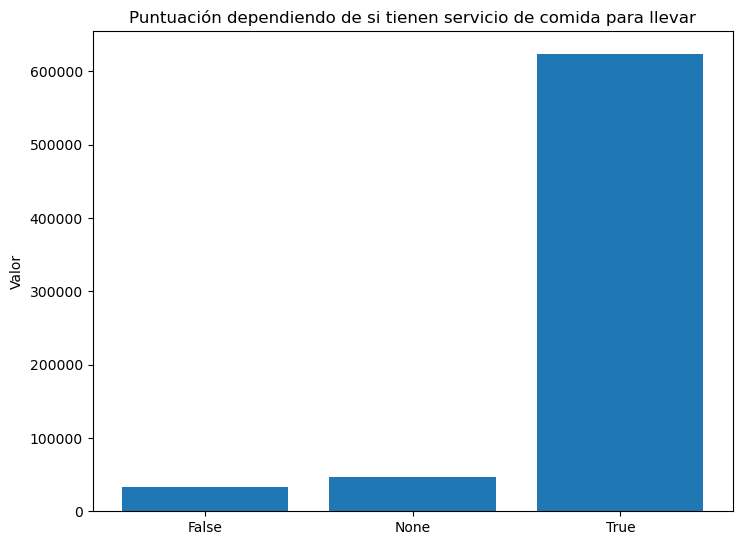

In [29]:
# We create a dataframe by grouping the data based on take_out and adding the stars.
take_stars = reviews_df[['take_out', 'stars']].groupby('take_out')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = list(take_stars['take_out'])
stars = take_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación dependiendo de si tienen servicio de comida para llevar')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si dispone de servicio de comida para llevar, False si no y None si se desconoce. Los restaurantes que sí tienen, obtienen puntuaciones más altas.

#### Puntuación según Wifi

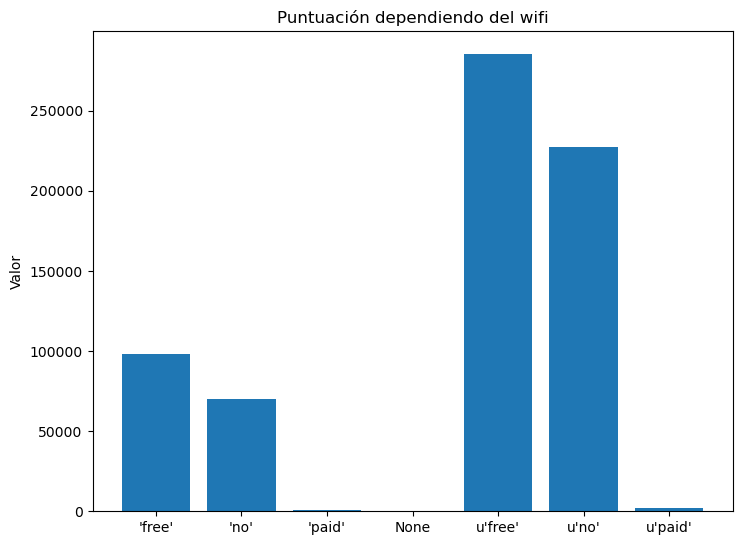

In [30]:
# We create a dataframe by grouping the data based on wifi and adding the stars.
wifi_stars = reviews_df[['wifi', 'stars']].groupby('wifi')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = list(wifi_stars['wifi'])
stars = wifi_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación dependiendo del wifi')
ax.set_ylabel('Valor')
plt.show()

La variable toma los valores Free si dispone de wifi gratis; paid si dispone de wifi pero pagando; no si no tienen y None si se desconoce. Los restaurante que ofrecen wifi gratis son los que tienen más probabilidad de tener mayores puntuaciones aunque los que no tienen también tienen puntuaciones más altas. Los usuarios prefieren esas opciones a tener que pagarlo, que es lo que peor puntuación obtiene. Las categorias están duplicadas, las trataremos en el preprocesado.

#### Puntuación según alcohol 

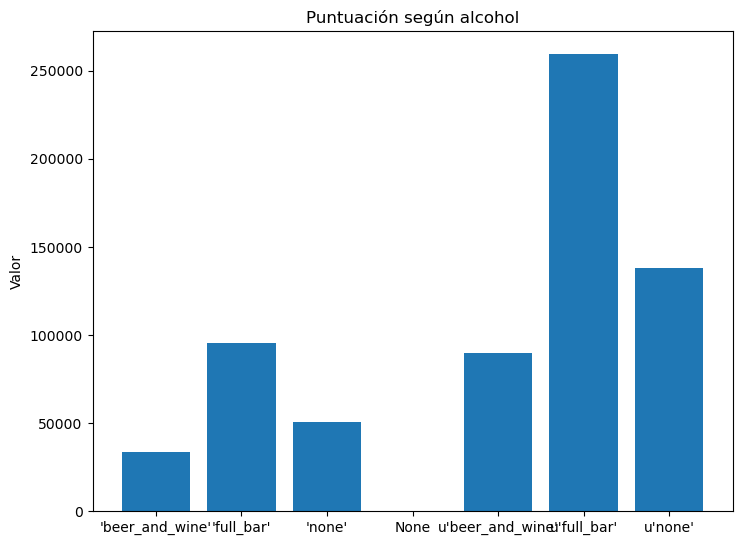

In [31]:
# We create a dataframe by grouping the data based on alcohol and adding the stars.
alcohol_stars = reviews_df[['alcohol', 'stars']].groupby('alcohol')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = list(alcohol_stars['alcohol'])
stars = alcohol_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación según alcohol')
ax.set_ylabel('Valor')
plt.show()

La variable toma los valores beer_and_wine si solo ofrecen cerveza y vino; full_bar si tienen todo tipo de alcohol y None si se desconoce. Los que ofrecen todo tipo de alcoholes son los que claramente obtienen mejores reseñas, les siguen los que se desconoce, y por último, los que solo ofrecen cerveza y vino.Las categorias están duplicadas, las trataremos en el preprocesado.

#### Puntuación según catering

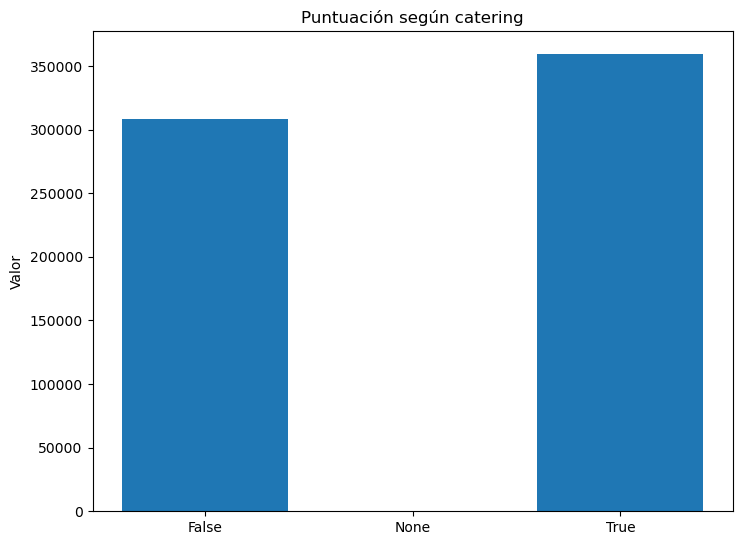

In [32]:
# We create a dataframe by grouping the data based on caters and adding the stars.
caters_stars = reviews_df[['caters', 'stars']].groupby('caters')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = list(caters_stars['caters'])
stars = caters_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación según catering')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si dispone de servicio de catering, False si no y None si se desconoce. Los restaurantes que sí tienen, obtienen puntuaciones más altas.

#### Puntuación según la accesibilidad con silla de ruedas.

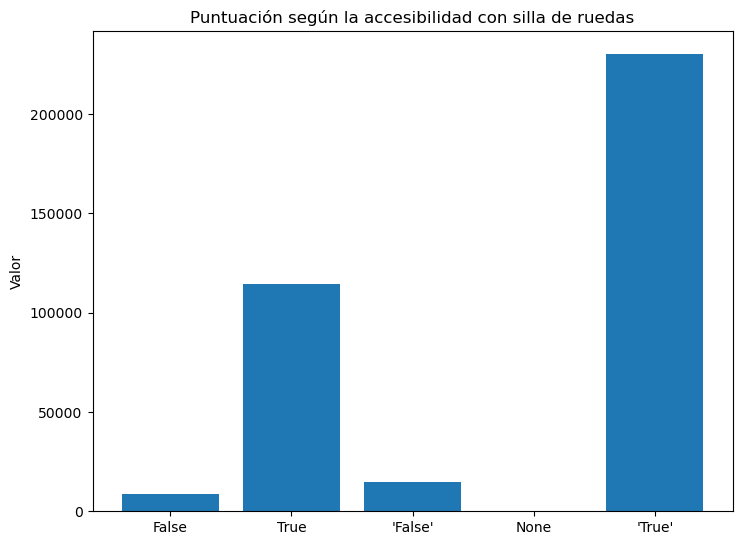

In [33]:
# We create a dataframe by grouping the data based on wheelchair_accessible and adding the stars.
wheelchair_stars = reviews_df[['wheelchair_accessible', 'stars']].groupby(
    'wheelchair_accessible')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ["False", "True", "'False'", "None", "'True'"]
stars = wheelchair_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación según la accesibilidad con silla de ruedas')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si se puede acceder al restaurante con silla de ruedas, False si no y None si se desconoce. Los restaurantes que son accesibles, obtienen puntuaciones más altas.

#### Puntuación dependiendo de si es bueno para niños.

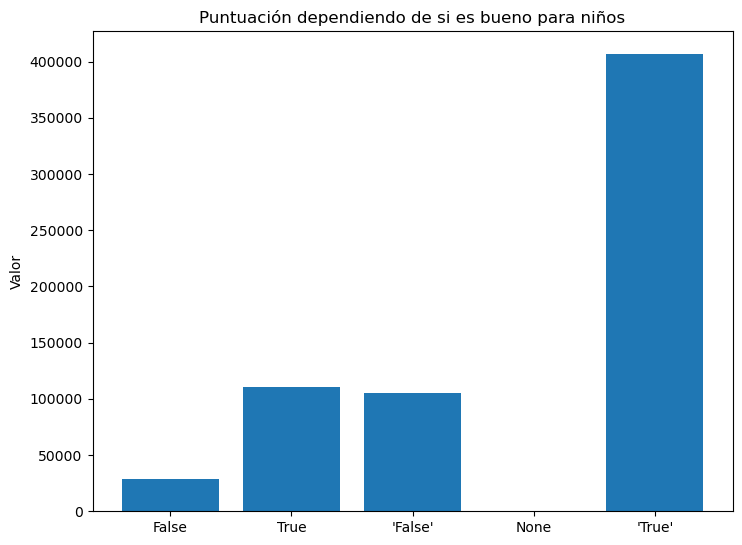

In [34]:
# We create a dataframe by grouping the data based on good_for_kids and adding the stars.
kids_stars = reviews_df[['good_for_kids', 'stars']].groupby(
    'good_for_kids')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ["False", "True", "'False'", "None", "'True'"]
stars = kids_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación dependiendo de si es bueno para niños')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si es un restaurante apto para niños, False si no y None si se desconoce. Los restaurantes que lo son, es más probable que obtengan puntuaciones más altas.

#### Puntuación según la vestimenta. 

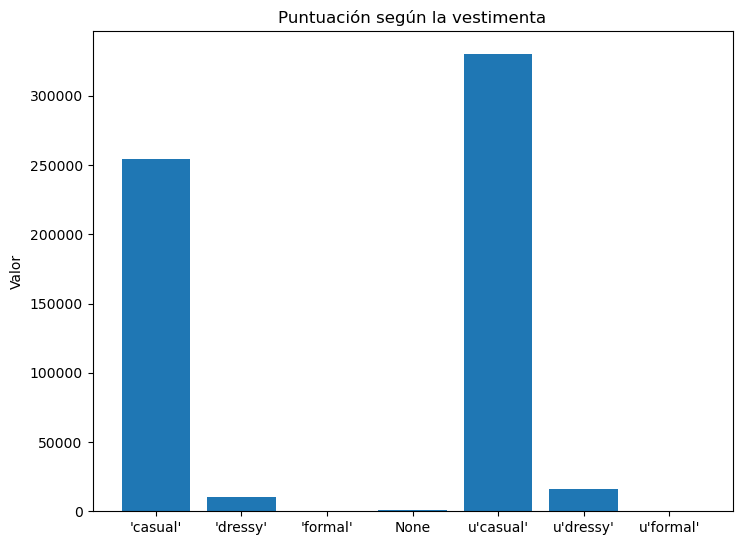

In [35]:
# We create a dataframe by grouping the data based on attire and adding the stars.
attire_stars = reviews_df[['attire', 'stars']].groupby(
    'attire')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = list(attire_stars['attire'])
stars = attire_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación según la vestimenta')
ax.set_ylabel('Valor')
plt.show()

Esta variable indica el tipo de vestimenta que se recomienda en el restaurante. Toma el valor casual, si es una vestimenta informal; dressy si es formal pero no demasiado y formal es algo más elegante que dressy. Los establecimientos que tienen un dresscode casual es más probable que tengan más estrellas que los que piden uno más elegante y formal. Las categorias están duplicadas, las trataremos en el preprocesado.

#### Puntuación según reservas. 

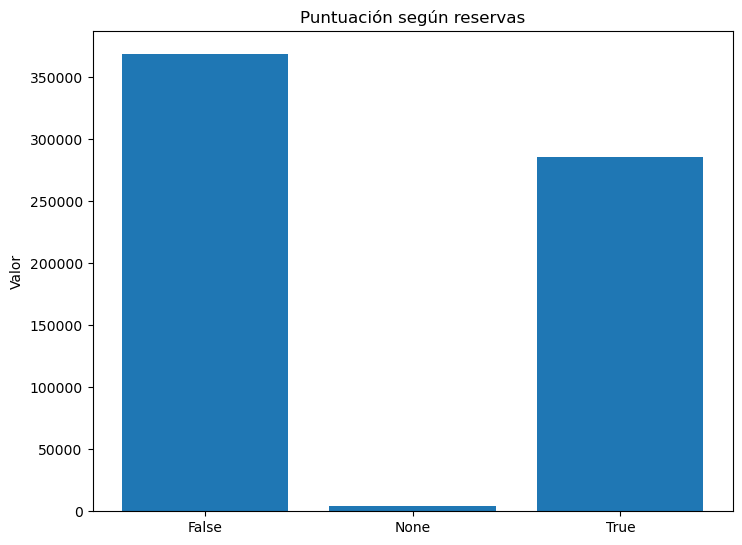

In [36]:
# We create a dataframe by grouping the data based on reservations and adding the stars.
reservations_stars = reviews_df[['reservations', 'stars']].groupby(
    'reservations')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = list(reservations_stars['reservations'])
stars = reservations_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación según reservas')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si para asistir al restaurante es necesario tener reserva, False si no y None si se desconoce. Los restaurantes en los que no es necesario, es más probable que obtengan puntuaciones más altas.

#### Puntuación según servicio a mesa

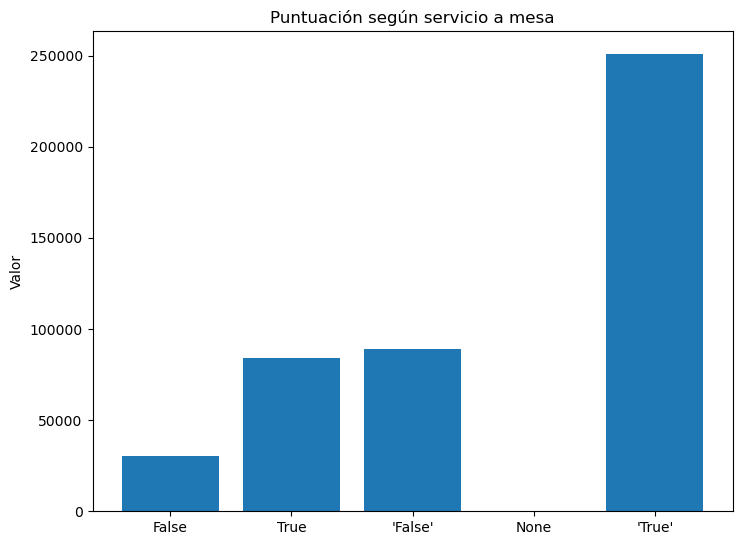

In [37]:
# We create a dataframe by grouping the data based on table_service and adding the stars.
table_stars = reviews_df[['table_service', 'stars']].groupby(
    'table_service')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ["False", "True", "'False'", "None", "'True'"]
stars = table_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación según servicio a mesa')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si es un restaurante dispone de servicio a mesa, False si no y None si se desconoce. Los restaurantes que tienen, es más probable que obtengan puntuaciones más altas. Los clientes prefieren que les sirvan en su propia mesa a tener que servirse ellos mismos. Las categorias estan duplicadas, en el preprocesado las uniremos.

#### Puntuación dependiendo de si es bueno para grupos. 

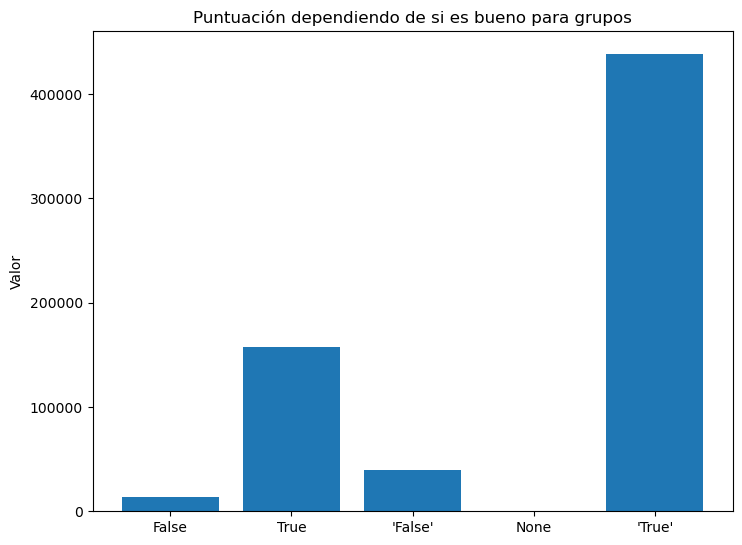

In [38]:
# We create a dataframe by grouping the data based on good_for_groups and adding the stars.
group_stars = reviews_df[['good_for_groups', 'stars']].groupby(
    'good_for_groups')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ["False", "True", "'False'", "None", "'True'"]
stars = group_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación dependiendo de si es bueno para grupos')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si es un restaurante apto para grupos, False si no y None si se desconoce. Los restaurantes que lo son, es más probable que obtengan puntuaciones más altas. Las categorias estan duplicadas, en el preprocesado las uniremos.

#### Puntuación dependiendo de si tiene televisión.

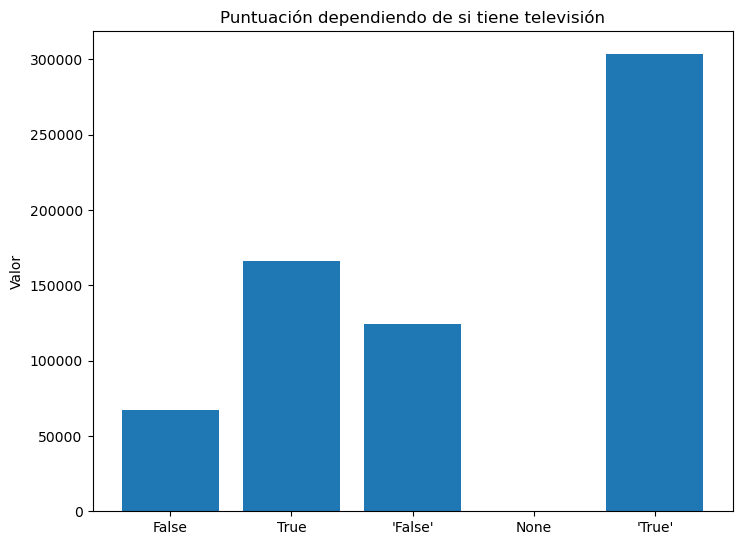

In [39]:
# We create a dataframe by grouping the data based on tv and adding the stars.
tv_stars = reviews_df[['tv', 'stars']].groupby('tv')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = ["False", "True", "'False'", "None", "'True'"]
stars = tv_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación dependiendo de si tiene televisión')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor True si dispone de televisión, False si no y None si se desconoce. Los restaurantes que sí tienen, es más probable que obtengan puntuaciones más altas. Las categorias estan duplicadas, en el preprocesado las uniremos.

#### Puntuación según nivel de ruido.

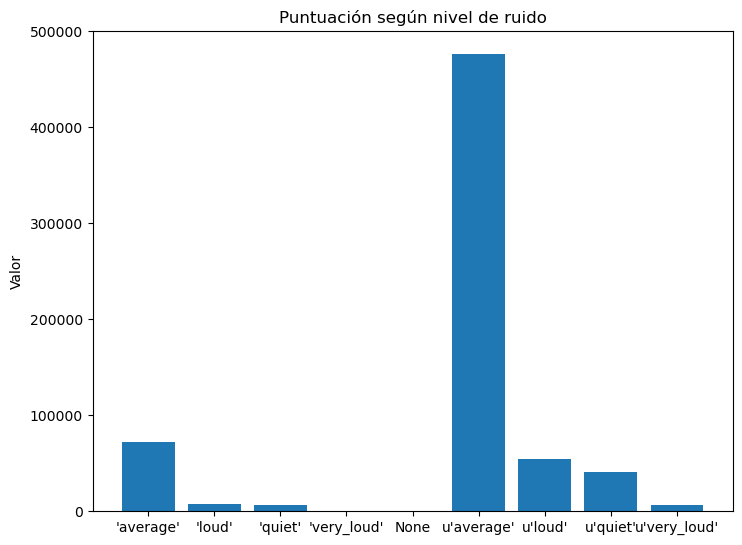

In [40]:
# We create a dataframe by grouping the data based on noise_level and adding the stars.
noise_stars = reviews_df[['noise_level', 'stars']].groupby('noise_level')['stars'].sum().to_frame().reset_index()

# We visualize the data
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
lab = list(noise_stars['noise_level'])
stars = noise_stars['stars']
ax.bar(lab, stars)
ax.set_title('Puntuación según nivel de ruido')
ax.set_ylabel('Valor')
plt.show()

La variable toma el valor average si es un ruido moderado; loud si es fuerte, quiet si es tranquilo, very_loud si es muy fuerte y None si se desconoce. Los que mayor valoración obtienen son los que tienen ruido moerado, les siguen los que tienen un ruido fuerte y después los que son más tranquilos. Los peor valorados son los que tienen un ruido muy fuerte. Las categorías están duplicadas, lo solucionaremos en el preprocesado.

Como conclusión, la mayoría de estos atributos son aspectos positivos, por lo que los usuarios valoran con mayor puntuación los restaurantes que ofrecen más servicios. No obstante, hay algunos atributos que no parecen tan importantes o prefieren que no los haya. Por tanto, los atributos que llevarían a un restaurante a alcanzar una puntuación alta serían:

- Disponer de reparto a domicilio.
- Disponer de terraza.
- Aceptar tarjeta de crédito como método de pago.
- Disponer de aparcamiento de bicicletas.
- Tener unos precios bajos - medios.
- Servicio para llevar.
- Wifi gratis.
- Tener todo tipo de alcohol.
- Tener entrada accesible para personas en silla de ruedas.
- Ser un sitio adecuado para niños.
- **Vestimenta casual.**
- **No pedir reserva.**
- Disponer de servicio a mesa.
- Ser un sitio adecuado para grupos.
- Disponer de televisión.
- **Ruido moderado o fuerte.**

#### Correlación entre variables categóricas

A continuación, vamos a calcular el coeficiente de correlación de Cramer para las variables categóricas.

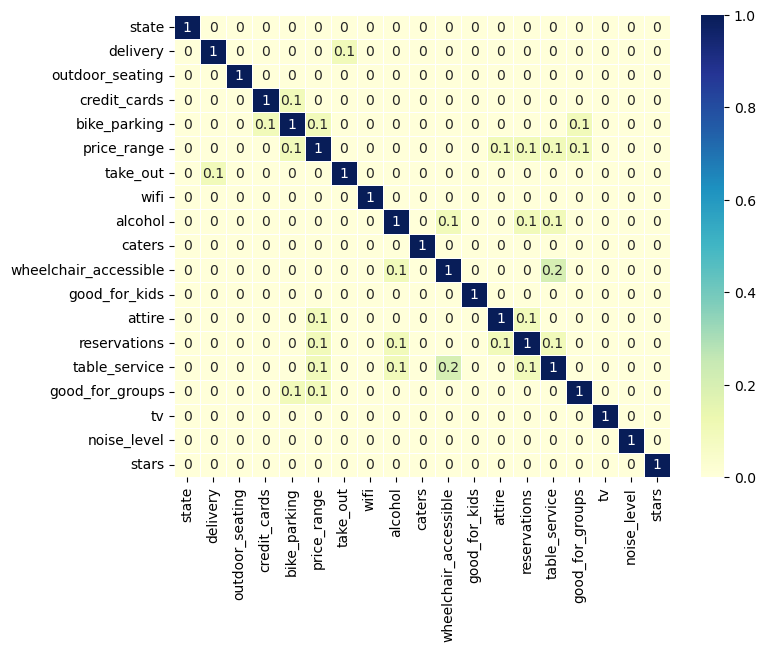

In [41]:
rows= []

for i1 in var_category:
    col = []
    for i2 in var_category:
        cramers = cramers_V(reviews_df[i1], reviews_df[i2]) # Cramer's V test
        col.append(round(cramers,1)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_results = np.array(rows)
v_c = pd.DataFrame(cramers_results, columns = var_category, index = var_category)

plt.figure(figsize=(8,6))
sns.heatmap(v_c, cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

Las correlaciones entre las variables son muy bajas, las que más correlacionafas están son *Wheelchair_accessible y table_service* que alcanzan un 0.2, aun así este valor sigue siendo muy bajo.

### 5.2 Variables numéricas.

#### Tratamiento de outliers.

Los vamos a calcular con la función *get_deviation_of_mean_perc*, que calcula el porcentaje de valores que se alejan de la media.

In [42]:
get_deviation_of_mean_perc(reviews_df, var_num, target='stars', multiplier=3)

,1.0,0.0,variable,sum_outlier_values,porcentaje_sum_outlier_values
0,0.797943,0.202057,useful,13224,0.013099
1,0.747063,0.252937,funny,11493,0.011384
2,0.866609,0.133391,cool,12737,0.012616


No hay outliers significativos ya que solo son el 1%, por lo que no vamos a aplicarles ninguna transformación.

#### Correlación entre variables numéricas.

Para este tipo de variables vamos a calcular la correlación de Pearson.

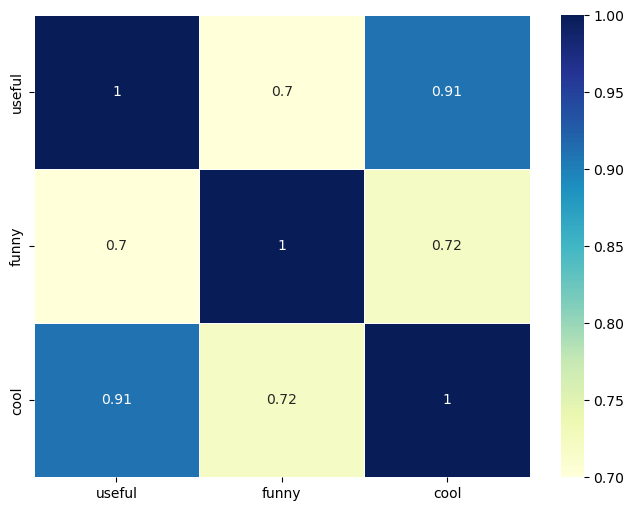

In [43]:
plt.figure(figsize=(8,6))
sns.heatmap(round(reviews_df[var_num].corr('pearson'),2), cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

Estas variables están bastante correlacionadas, el coeficiente más bajo que hemos obtenido es 0,69. *Useful* y *cool* son las que están más correlacionadas, alcanzando un 0,91, no obstante no las vamos a eliminar dado que cada una indica la valoración que otro usuario (no el que ha puesto la reseña) ha dado a esa reseña y son categorías distintas. Las reseñas se pueden valorar con useful (si la consideran útil), funny (si la consideran divertida) y cool (si la consideran *guay*), y el valor de la variable es el número de usuarios que la han calificado de esa manera.

In [44]:
# Finally, before saving the data we are going to eliminate some variables that we are not going to use in the model.
# We had left user_id y business_id until now because they were useful for analyzing duplicates and make the graph.
# We eliminated review_count because it doesn't give us anything, we only wanted it to filter by users.
reviews_df = reviews_df.drop(['user_id', 'business_id', 'review_count'], axis=1)

## 6. Exportación de los datos

Por último, vamos a exportar los datos ya procesados.

In [45]:
reviews_df.to_csv('../data/processed/data_reviews.csv', index=False)